#### Preliminaries

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.model_selection import LeaveOneOut, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.kernel_ridge import KernelRidge

#### Data loading, dropping production

In [2]:
data = pd.read_csv('../data/Table2_Hunt_2013_edit.csv')

In [3]:
features = data.loc[:, ['Position', 'Gross pay', 'Phi-h', 'Pressure', 'Random 1', 'Random 2', 'Gross pay transform']]
features.describe()

,Position,Gross pay,Phi-h,Pressure,Random 1,Random 2,Gross pay transform
count,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000
mean,1.885714,9.823810,68.880952,15.285714,10.190476,292.714286,16.579524
std,0.708721,5.948521,45.167894,2.759400,6.439092,59.429069,6.543793
min,1.000000,0.100000,0.500000,10.000000,1.000000,210.000000,3.540000
25%,1.100000,4.900000,24.600000,14.000000,6.000000,245.000000,11.520000
50%,2.000000,10.000000,72.900000,16.000000,10.000000,273.000000,16.900000
75%,2.200000,15.100000,100.000000,17.000000,13.000000,340.000000,21.970000
max,2.900000,19.100000,160.000000,20.000000,21.000000,395.000000,29.250000


### Sequential BACKWARD Feature Selection with Linear regression

In [4]:
X = features.values

In [5]:
y = data.loc[:, ['Production']].values

In [6]:
loo = LeaveOneOut()

In [7]:
LR = LinearRegression()

sfs = SFS(estimator=LR, 
          k_features=1, 
          forward=False, 
          floating=True, 
          scoring='neg_mean_squared_error',
          cv = loo,
          n_jobs = -1)

sfs = sfs.fit(X, y)

#### Plotting results

Plot function modified from:  https://github.com/rasbt/mlxtend/blob/master/mlxtend/plotting/plot_sequential_feature_selection.py

In [8]:
# Sebastian Raschka 2014-2019
# mlxtend Machine Learning Library Extensions
#
# Algorithm for plotting sequential feature selection.
# Author: Sebastian Raschka <sebastianraschka.com>
#
# License: BSD 3 clause

##### Added by Matteo ######
font = {'size'   : 18}
plt.rc('font', **font) 
plt.rc('ytick',labelsize=18)
############################


def plot_sequential_feature_selection(metric_dict,
                                      kind='std_dev',
                                      color='blue',
                                      bcolor='steelblue',
                                      marker='o',
                                      alpha=0.2,
                                      ylabel='Performance',
                                      confidence_interval=0.95):
    """Plot feature selection results.

    Parameters
    ----------
    metric_dict : mlxtend.SequentialFeatureSelector.get_metric_dict() object
    kind : str (default: "std_dev")
        The kind of error bar or confidence interval in
        {'std_dev', 'std_err', 'ci', None}.
    color : str (default: "blue")
        Color of the lineplot (accepts any matplotlib color name)
    bcolor : str (default: "steelblue").
        Color of the error bars / confidence intervals
        (accepts any matplotlib color name).
    marker : str (default: "o")
        Marker of the line plot
        (accepts any matplotlib marker name).
    alpha : float in [0, 1] (default: 0.2)
        Transparency of the error bars / confidence intervals.
    ylabel : str (default: "Performance")
        Y-axis label.
    confidence_interval : float (default: 0.95)
        Confidence level if `kind='ci'`.

    Returns
    ----------
    fig : matplotlib.pyplot.figure() object

    Examples
    -----------
    For usage examples, please see
    http://rasbt.github.io/mlxtend/user_guide/plotting/plot_sequential_feature_selection/

    """

    allowed = {'std_dev', 'std_err', 'ci', None}
    if kind not in allowed:
        raise AttributeError('kind not in %s' % allowed)

    fig = plt.figure(figsize=(14,12)) 
    k_feat = sorted(metric_dict.keys())
    avg = [metric_dict[k]['avg_score'] for k in k_feat]

    if kind:
        upper, lower = [], []
        if kind == 'ci':
            kind = 'ci_bound'

        for k in k_feat:
            upper.append(metric_dict[k]['avg_score'] +
                         metric_dict[k][kind])
            lower.append(metric_dict[k]['avg_score'] -
                         metric_dict[k][kind])

        plt.fill_between(k_feat,
                         upper,
                         lower,
                         alpha=alpha,
                         color=bcolor,
                         lw=1)

        if kind == 'ci_bound':
            kind = 'Confidence Interval (%d%%)' % (confidence_interval * 100)

    plt.plot(k_feat, avg, color=color, marker=marker)
    plt.ylabel(ylabel)
    plt.xlabel('Number of Features')
    feature_min = len(metric_dict[k_feat[0]]['feature_idx'])
    feature_max = len(metric_dict[k_feat[-1]]['feature_idx'])
    plt.xticks(range(feature_min, feature_max + 1),
               range(feature_min, feature_max + 1))
    return fig

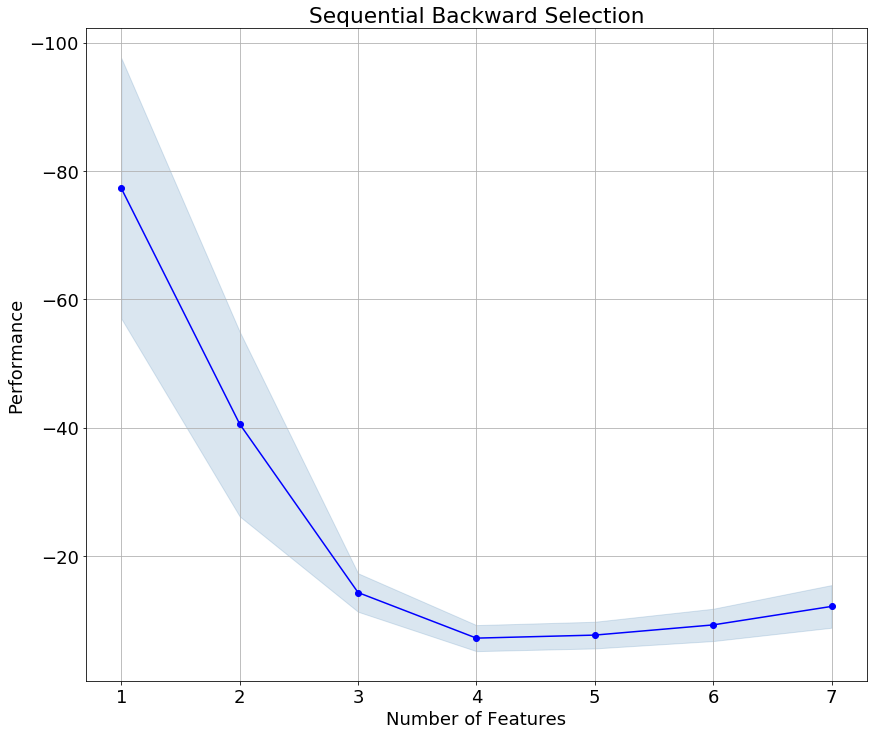

In [9]:
plot_sequential_feature_selection(sfs.get_metric_dict(), kind='std_err')
plt.title('Sequential Backward Selection')

plt.grid()
plt.gca().invert_yaxis();

#### Save results to dataframe

In [10]:
selected_summary = pd.DataFrame.from_dict(sfs.get_metric_dict()).T
selected_summary['index'] = selected_summary.index
selected_summary.sort_values(by='avg_score', ascending=0)

,avg_score,ci_bound,cv_scores,feature_idx,feature_names,std_dev,std_err,index
4,-7.21576,4.22087,"[-16.29949342891783, -0.27293368410213237, -5....","(0, 1, 2, 3)","(0, 1, 2, 3)",9.07683,2.02964,4
5,-7.68695,4.32124,"[-17.240275443538813, -0.914829402814391, -7.3...","(0, 1, 2, 3, 4)","(0, 1, 2, 3, 4)",9.29267,2.0779,5
6,-9.27588,5.23563,"[-30.68734559577946, -0.382576309729883, -8.33...","(0, 1, 2, 3, 4, 6)","(0, 1, 2, 3, 4, 6)",11.259,2.5176,6
7,-12.1561,6.90979,"[-41.54727896993002, -0.01765014967685895, -5....","(0, 1, 2, 3, 4, 5, 6)","(0, 1, 2, 3, 4, 5, 6)",14.8593,3.32263,7
3,-14.3201,6.22978,"[-15.80179265395075, -3.214416151317504, -0.95...","(0, 1, 3)","(0, 1, 3)",13.3969,2.99564,3
2,-40.576,29.923,"[-25.976143595660844, -0.14395649922134976, -1...","(0, 1)","(0, 1)",64.3484,14.3887,2
1,-77.2993,42.2025,"[-10.808128130366436, -67.99831861802683, -55....","(1,)","(1,)",90.7549,20.2934,1


#### Obtaining the best k feature 

In [11]:
feature_idx = np.array(selected_summary.loc[4]['feature_idx'])
feature_idx

array([0, 1, 2, 3])

In [12]:
selected = features.iloc[:,feature_idx]
print(list(selected))

['Position', 'Gross pay', 'Phi-h', 'Pressure']


In [13]:
selected

,Position,Gross pay,Phi-h,Pressure
0,2.1,0.1,0.5,19
1,1.1,1.0,4.0,16
2,1.0,1.9,19.0,14
3,2.1,3.1,21.7,17
4,2.9,4.1,24.6,11
5,1.1,4.9,39.2,12
6,2.1,5.9,23.6,13
7,2.0,7.0,63.0,13
8,2.9,8.1,72.9,14
9,2.8,8.9,35.6,16


### Sequential FORWARD Feature Selection with Linear regression

In [14]:
LR = LinearRegression()

sfs = SFS(estimator=LR, 
          k_features=7, 
          forward=True, 
          floating=True, 
          scoring='neg_mean_squared_error',
          cv = loo,
          n_jobs = -1)

sfs = sfs.fit(X, y)

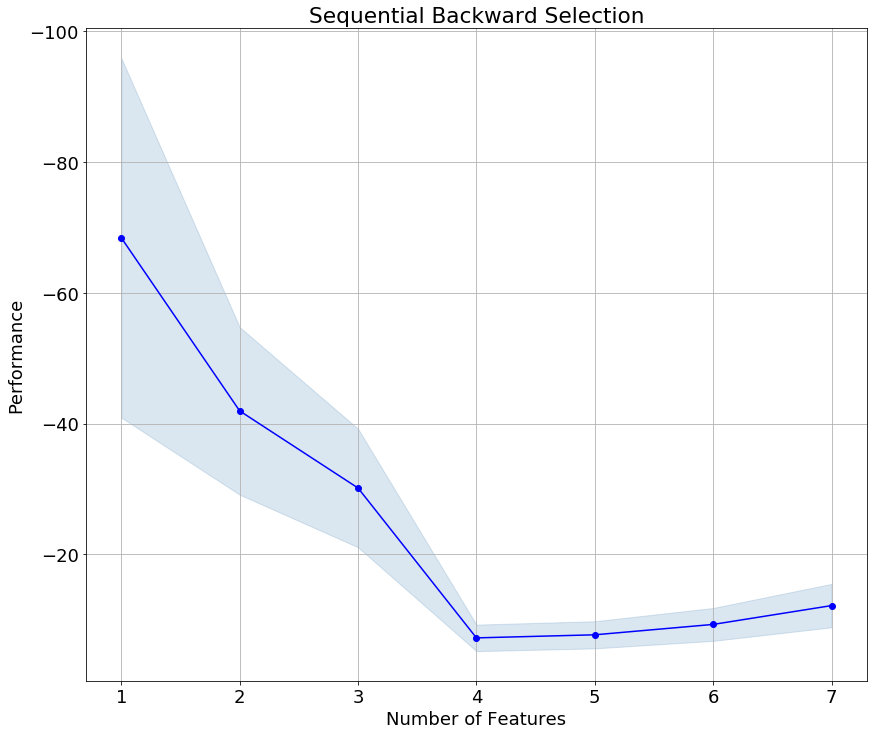

In [15]:
plot_sequential_feature_selection(sfs.get_metric_dict(), kind='std_err')
plt.title('Sequential Backward Selection')

plt.grid()
plt.gca().invert_yaxis();

#### Save results to dataframe

In [16]:
selected_summary = pd.DataFrame.from_dict(sfs.get_metric_dict()).T
selected_summary['index'] = selected_summary.index
selected_summary.sort_values(by='avg_score', ascending=0)

,avg_score,ci_bound,cv_scores,feature_idx,feature_names,std_dev,std_err,index
4,-7.21576,4.22087,"[-16.29949342891783, -0.27293368410213237, -5....","(0, 1, 2, 3)","(0, 1, 2, 3)",9.07683,2.02964,4
5,-7.68695,4.32124,"[-17.240275443538813, -0.914829402814391, -7.3...","(0, 1, 2, 3, 4)","(0, 1, 2, 3, 4)",9.29267,2.0779,5
6,-9.27588,5.23563,"[-30.68734559577946, -0.382576309729883, -8.33...","(0, 1, 2, 3, 4, 6)","(0, 1, 2, 3, 4, 6)",11.259,2.5176,6
7,-12.1561,6.90979,"[-41.54727896993002, -0.01765014967685895, -5....","(0, 1, 2, 3, 4, 5, 6)","(0, 1, 2, 3, 4, 5, 6)",14.8593,3.32263,7
3,-30.1421,18.8553,"[-74.17343647698772, -0.0011006227301459455, -...","(0, 2, 3)","(0, 2, 3)",40.5477,9.06673,3
2,-41.9401,26.6575,"[-75.57932114882955, -31.885236740060652, -45....","(2, 3)","(2, 3)",57.3261,12.8185,2
1,-68.4167,57.1842,"[-2.3033552129713235, -58.01553074927203, -16....","(2,)","(2,)",122.972,27.4975,1


#### Obtaining the best k feature 

In [17]:
feature_idx = np.array(selected_summary.loc[4]['feature_idx'])
feature_idx

array([0, 1, 2, 3])

In [18]:
selected = features.iloc[:,feature_idx]
print(list(selected))

['Position', 'Gross pay', 'Phi-h', 'Pressure']


In [19]:
selected

,Position,Gross pay,Phi-h,Pressure
0,2.1,0.1,0.5,19
1,1.1,1.0,4.0,16
2,1.0,1.9,19.0,14
3,2.1,3.1,21.7,17
4,2.9,4.1,24.6,11
5,1.1,4.9,39.2,12
6,2.1,5.9,23.6,13
7,2.0,7.0,63.0,13
8,2.9,8.1,72.9,14
9,2.8,8.9,35.6,16
